In [217]:
import numpy as np
import choix
import opt_fair_multi as opt_fair
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from matplotlib import colors
import scipy.sparse as sp

In [218]:
size = 100 #number of items
min_sizes = [30, 30]  

num_reviewers = 50 #number of reviewers
pair_per_reviewer = 100 #number of pairs evaluated per reviewer

In [232]:
#init original scores
np.random.seed(45)
import numpy as np

def generate_classes(size, min_sizes):
    result_array = np.empty((len(min_sizes), size))
    for i, min_size in enumerate(min_sizes):
        binary_array = np.zeros(size)
        binary_array[:min_size] = 1
        np.random.shuffle(binary_array)
        result_array[i, :] = binary_array
    return result_array.T

classes = generate_classes(size, min_sizes)
np.shape(classes)

(100, 2)

In [233]:
np.random.seed(43)

std = 5
scores = np.random.normal(0,std ,size = size)

In [234]:
rep = 5
mean_bias_M = [x/2 for x in [0,1,2,3,4,5,6,7,8,9,10]]
annot_bt_M = np.zeros((len(mean_bias_M),rep))
bt_M = np.zeros((len(mean_bias_M),rep))
rank_centrality_M = np.zeros((len(mean_bias_M),rep))
crowd_bt_M = np.zeros((len(mean_bias_M),rep))
factor_bt_M = np.zeros((len(mean_bias_M),rep))

In [235]:
revs_bias = np.column_stack([
    np.random.normal(loc=2, scale=0.1, size=num_reviewers),
    np.random.normal(loc=3, scale=0.1, size=num_reviewers)
])
revs_bias.shape

(50, 2)

In [236]:
def create_pairwise_comparisons(scores, classes, revs_bias, pair_per_reviewer):
    pairwise_comparisons = {}
    
    for i in range(revs_bias.shape[0]):
        pairs = []
        items = np.arange(len(scores))
        for _ in range(pair_per_reviewer):

            a, b = np.random.choice(items, size=2, replace=False) #replace = False to ensure a != b
            #while (a, b) in pairs or (b, a) in pairs: #sample the pair, in this version instead the reviewer can evaluate the same pair only once
                #a, b = np.random.choice(numbers, size=2, replace=False)

            #make them play
            bias_a = np.dot(classes[a,:],revs_bias[i,:])
            bias_b = np.dot(classes[b,:],revs_bias[i,:])
            if np.random.rand() < (np.exp(scores[a] + bias_a)/(np.exp(scores[a] + bias_a) + np.exp(scores[b] + bias_b))):
            #if scores[a]>scores[b]: #deterministic version
            # this block of code will be executed with probability p
                pairs.append((a, b)) #who win is the first of the pair!!! i.e. a won
            else:
            # this block of code will be executed with probability 1-p   
                pairs.append((b, a)) #b won
        
        #save the pc for reviewer i
        pairwise_comparisons.update({i: pairs})

    return pairwise_comparisons


In [237]:
pairwise_comparisons = create_pairwise_comparisons(scores, classes, revs_bias, pair_per_reviewer)
all_pc  = opt_fair._pc_without_reviewers(pairwise_comparisons)
pairwise_comparisons[0][0]

(11, 44)

In [238]:
def _matrix_of_comparisons(size,l, reg = 1):
    ''' Input: 
    size = the number of items
    l = the list of pairwise comparisons (a list of pairs, with the first of the pair is the one that has been preferred)
    reg = a regularizer to ensure that the network is connected    
        Output:
    a (size x size) matrix, where a_ij represents the fraction of times object j has been preferred to
    object i'''
    
    A = np.zeros((size,size))
    for i,j in l:
        A[j,i] += 1 #i won
    
    B = np.zeros((size,size)) 
    for i in range(size):
        for j in range(size):
            if A[i,j]!=0:
                B[i,j] = A[i,j]/(A[i,j] + A[j,i])
                
    return B + reg * (np.ones((size,size)) - np.eye(size))
    

In [239]:
def crowd_alternate_optim(size, num_reviewers, pc_with_revs, iters = 101, tol = 1e-5, gtol = 1e-5):
    '''x0 is the estimated scores
       y0 is the estimated bias for each reviewer'''
    x0 = np.zeros(size)
    y0 = np.ones(num_reviewers)*0.7
    bounds = [(0, 1)] * len(y0)


    for i in range(iters):

        
        
        # minimize with y fixed and update x
        res_x = minimize(lambda x: pc_with_revs.crowdbt_objective(x, y0), x0,tol = tol,  jac=lambda x: pc_with_revs.crowdbt_gradient_scores(x, y0), options={"gtol": gtol,'maxiter': 1})
        x0 = res_x.x
        
        
        # minimize with x fixed and update y
        res_y = minimize(lambda y: pc_with_revs.crowdbt_objective(x0, y), y0,tol = tol, jac=lambda y: pc_with_revs.crowdbt_gradient_revs(x0, y), bounds=bounds, options={"gtol": gtol,'maxiter': 1})
        y0 = res_y.x

        #if ((i) % 100 == 0):
            #print(f"Iteration {i}: x = {x0}, y = {y0}")
            #print(res_x.success)
            #print(res_y.success)

        if res_x.success and res_y.success:
            #print("Minimum found!")
            #print(f"Iteration {i}: x = {x0}, y = {y0}")
            #print(res_x.success)
            #print(res_y.success)
            break
    return x0,y0


In [240]:
def FactorBT_alternate_optim(size, num_reviewers, pc_with_revs, iters = 101, tol = 1e-5, gtol = 1e-5):
    '''x0: is the estimated scores
       y0: is the estimated bias for each reviewer - i.e. gamma/g
       Z0: is the estimated bias for each reviewer - i.e. r 
       '''
    x0 = np.zeros(size)
    y0 = np.ones(num_reviewers)*0.7
    z0 = np.zeros(num_reviewers)
    bounds = [(0, 1)] * len(y0)



    for i in range(iters):

        # minimize with x,z fixed and update y
        res_y = minimize(lambda y: pc_with_revs.FactorBT_objective(x0, y, z0), y0,tol = tol, jac=lambda y: pc_with_revs.FactorBT_gradient_g(x0, y, z0),bounds=bounds, options={"gtol": gtol,'maxiter': 1})
        y0 = res_y.x
        
        res_z = minimize(lambda z: pc_with_revs.FactorBT_objective(x0, y0, z), z0,tol = tol, jac=lambda z: pc_with_revs.FactorBT_gradient_r(x0, y0, z), options={"gtol": gtol,'maxiter': 1})
        z0 = res_z.x

        # minimize with y,z fixed and update x
        res_x = minimize(lambda x: pc_with_revs.FactorBT_objective(x, y0, z0), x0,tol = tol, jac=lambda x: pc_with_revs.FactorBT_gradient_scores(x, y0, z0), options={"gtol": gtol,'maxiter': 1})
        x0 = res_x.x


        #if ((i) % 100 == 0):
            #print(f"Iteration {i}: x = {x0}, y = {y0}")
            #print(res_x.success)
            #print(res_y.success)

        if res_x.success and res_y.success:
            #print("Minimum found!")
            #print(f"Iteration {i}: x = {x0}, y = {y0}")
            #print(res_x.success)
            #print(res_y.success)
            break
    return x0,y0,z0




In [241]:
%%time
np.random.seed(38)
revs_bias = np.column_stack([
        np.random.normal(loc=-3, scale=0.1, size=num_reviewers),
        np.random.normal(loc=-3 - 1, scale=0.1, size=num_reviewers)
                                                                ])
revs_set =  create_pairwise_comparisons(scores, classes, revs_bias, pair_per_reviewer)
all_pc  = opt_fair._pc_without_reviewers(revs_set)


#BT
bt_temp = choix.opt_pairwise(size, all_pc, alpha=0, method='Newton-CG', initial_params=None, max_iter=None, tol=1e-05)


#BARP
pc_with_revs = opt_fair.Pairwise_with_rev(data = revs_set, penalty = 0, classes = classes)


annot_bt_temp,annot_bias =  opt_fair.barp_multi_alternate_optim(size, num_reviewers, pc_with_revs, classes, iters = 100)

        

CPU times: user 3min 27s, sys: 2min 31s, total: 5min 58s
Wall time: 2min 32s


In [242]:
def rank(scores):
    # Create a list of (index, score) tuples
    indexed_scores = list(enumerate(scores))

    # Sort the list of tuples based on the scores in ascending order
    sorted_scores = sorted(indexed_scores, key=lambda x: x[1])

    # Create a dictionary to store the ranks
    ranks = {}

    # Assign ranks to each element based on their sorted order
    for i, (index, score) in enumerate(sorted_scores):
        ranks[index] = i + 1

    # Create a list of ranks for the original order of elements
    result = [ranks[i] for i in range(len(scores))]

    return result



In [243]:
data1 = np.column_stack((rank(scores),rank(annot_bt_temp), classes))


data2 = np.column_stack((scores,annot_bt_temp, classes))

data3 = np.column_stack((rank(scores),rank(bt_temp), classes))

data4 = np.column_stack((scores,bt_temp, classes))


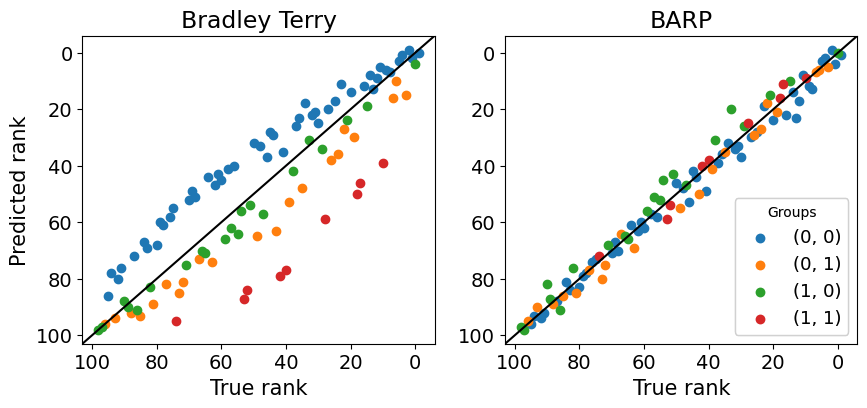

In [260]:
import numpy as np
import matplotlib.pyplot as plt

# Separate the data into different pairs for coloring
colors = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Create a scatterplot for the first subplot
for color_pair in colors:
    indices = np.where((data3[:, 2] == color_pair[0]) & (data3[:, 3] == color_pair[1]))
    axes[0].scatter(99-data3[indices, 0],99- data3[indices, 1], label=f'({color_pair[0]}, {color_pair[1]})')

# Create a scatterplot for the second subplot
for color_pair in colors:
    indices = np.where((data1[:, 2] == color_pair[0]) & (data1[:, 3] == color_pair[1]))
    axes[1].scatter(99-data1[indices, 0],99- data1[indices, 1], label=f'({color_pair[0]}, {color_pair[1]})')

axes[0].axline([0, 0], slope=1, color = 'black')
axes[1].axline([0, 0], slope=1, color = 'black')
    
# Set labels for both subplots
axes[0].set_xlabel('True rank', fontsize=15)
axes[0].set_ylabel('Predicted rank', fontsize=15)
axes[1].set_xlabel('True rank', fontsize=15)
#axes[1].set_ylabel('BARP rank', fontsize=18)

legend1 = axes[1].legend(title='Groups', fontsize=13, loc = 'lower right')
axes[1].add_artist(legend1)

axes[0].set_title('Bradley Terry', fontsize=17)
axes[1].set_title('BARP', fontsize=17)



# Set the overall title in the middle
#plt.suptitle('Comparison of Items Rankings', fontsize=20)

# Set font size for ticks
for ax in axes:
    ax.tick_params(axis='both', labelsize=14)


# Reverse the y-axis to have 0 at the top
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].invert_xaxis()
axes[1].invert_xaxis()

plt.savefig("../plots/multi_rank.pdf", bbox_inches="tight")
    
# Show the plot
plt.show()
